<a href="https://colab.research.google.com/github/PiotMik/spread-options/blob/feature%2FNotebook_Copulas/Copulas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bivariate copulas for crack spread option pricing

<img align="left" width="350" height="350" src="https://www.cmegroup.com/education/images/articles/2017/introduction-to-crack-spreads-01.jpg">


## Czym jest crack spread?

Crack spread to ([CME Group](https://www.cmegroup.com/education/articles-and-reports/introduction-to-crack-spreads.html#)):

* **Matematycznie**?

Różnica między ceną baryłki ropy naftowej a ceną produktu ropopochodnego który jest z niej przetworzony.

* **Finansowo**? 

Portfel: długiej pozycji na ropie naftowej (futures), oraz krótkiej pozycji na produkcie ropopochodnym (futures) 

### Różne definicje

Zawsze trzeba dopowiedzieć, jaki produkt ropopodobny mamy na myśli, oraz z jakiej lokalizacji geograficznej.
Przykładowo, my będziemy pracować z:
* Heating Oil: New York Harbor
* West Texas Intermediate crude oil (WTI)

## Opcje na spread

Najwygodniej po prostu pomyśleć o rożnicy cen dwóch aktywów (czyli spreadzie) jako o samoistnym instrumence finansowym $S_t$.
Wtedy można zapisać spread jako instrument finansowy uprawniający w momencie wygaśnięcia do wypłaty jako zwykłe wypłaty opcji waniliowych:

* Call option: $H_c(T, S; K) = \max{(S_T - K, 0)}$
* Put option: $H_p(T, S; K) = \max{(K - S_T, 0)}$

Powinniśmy jednak rozpisać dokładniej - jeśli mamy dwa aktywa $A_t$ i $B_t$ i interesuje nas opcja na ich spread $S_t = A_t - B_t$, to otrzymujemy:

* Spread call option: $H_c(T, A, B; K) = \max{(A_T - B_T - K, 0)}$
* Spread put option: $H_p(T, A, B; K) = \max{(K - A_T + B_T, 0)}$

In [6]:
import copulas as cp

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.covariance import EllipticEnvelope
from scipy.stats import norm, linregress

from statsmodels.graphics import tsaplots

sns.set()
plt.style.use('ggplot-ubs.mplstyle')
fmt = 'svg'
sns.set_context('poster')
plt.rcParams['figure.figsize'] = (14, 7)
palette = sns.color_palette(as_cmap=True)

In [7]:
# Jeśli kod wykonywany przez Google Colab, poniższe pozwala wgrać pliki z danymi:
# Należy wgrać: HO.csv (Heating Oil), CO.csv (Crude Oil).

# from google.colab import files
# uploaded = files.upload()

---

## Data
Dane pochodzą z https://www.macrotrends.net/.
Ściągnęliśmy kilka lat dziennych obserwacji:
* [Closing price for No. 2 Heating Oil: New York Harbor](https://www.macrotrends.net/2479/heating-oil-prices-historical-chart-data). The prices shown are in U.S. dollars.
* [West Texas Intermediate (WTI or NYMEX) crude oil prices per barrel](https://www.macrotrends.net/1369/crude-oil-price-history-chart). The price of oil shown is adjusted for inflation using the headline CPI

Olej grzewczy kwotowany jest w dolarach za galon, a ropa w dolarach za baryłkę. Sprowadzimy to do wspólnego mianownika - baryłek (baryłka to 42 galony). 

Nasze opcje będą więc mieć wypłaty postaci:

* Heating Oil - Crude Oil spread call option: $H_c(T, HO_T, CO_T; K) = \max{(42\cdot HO_T - CO_T - K, 0)}$
* Heating Oil - Crude Oil spread put option: $H_p(T, HO_T, CO_T; K) = \max{(K - 42\cdot HO_T + CO_T, 0)}$

In [8]:
ho_df = pd.read_csv('HO.csv', skiprows=13, index_col='date', parse_dates=True)
co_df = pd.read_csv('CO.csv', skiprows=13, index_col='date', parse_dates=True)

ho_df = ho_df.rename(columns={" value": "HeatingOil"})
ho_df.HeatingOil = ho_df.HeatingOil*42
co_df = co_df.rename(columns={" value": "CrudeOil"})

spread_df = pd.DataFrame(ho_df.HeatingOil - co_df.CrudeOil)
spread_df = spread_df.rename(columns={0: "Spread"})

pricing_df = pd.concat([ho_df, co_df, spread_df], axis=1)
pricing_df.dropna(inplace = True)

# drop stale data
stale_ind = np.where((pricing_df.diff() == 0.0).sum(axis=1) == 0)[0] 
pricing_df = pricing_df.iloc[stale_ind, :]
pricing_df = pricing_df.loc["2014-04-30":, :]

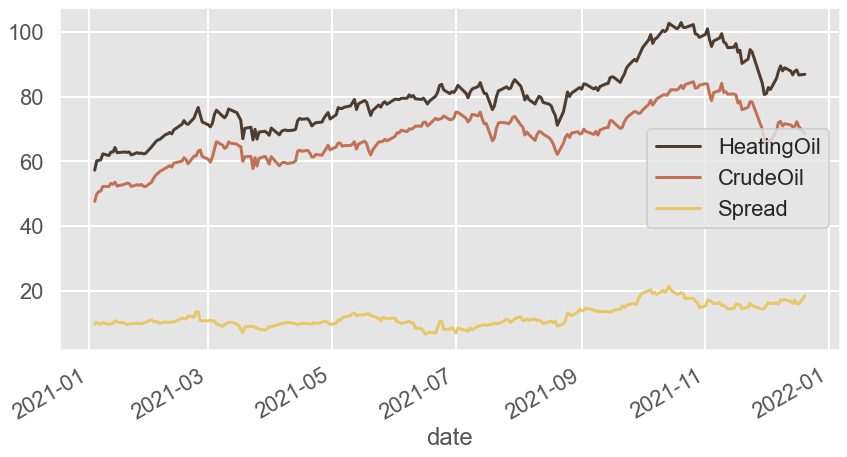

In [9]:
pricing_df.loc["2021-01-01":, :].plot()
plt.savefig(f'img/HistoricalData.{fmt}', format=fmt)

---

## Logreturns analysis

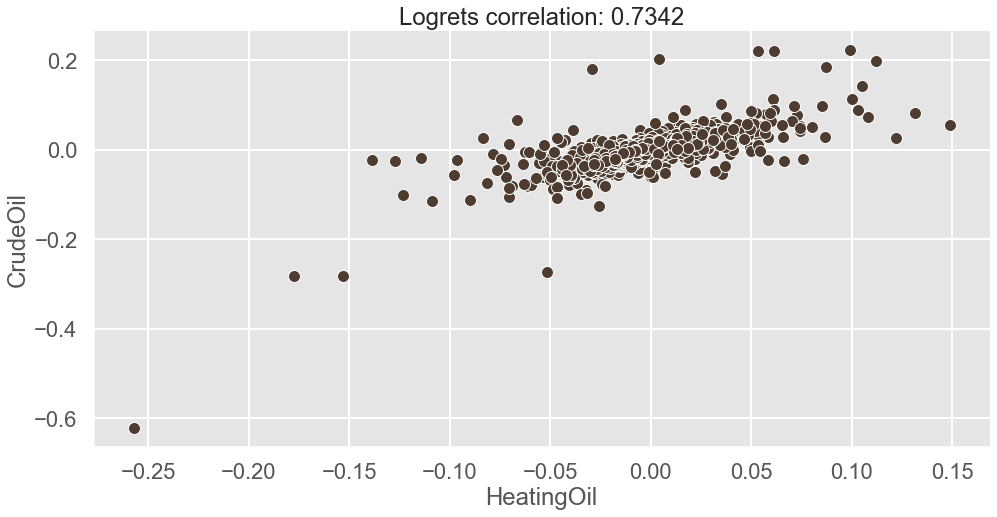

In [10]:
logrets_df = np.log(pricing_df).diff().dropna()
sns.relplot(data = logrets_df, x="HeatingOil", y="CrudeOil", height = 7, aspect=2)
corr = logrets_df.loc[:, ["HeatingOil", "CrudeOil"]].corr().iloc[1, 0]
_=plt.title(f"Logrets correlation: {corr:.4f}")
plt.savefig(f'img/LogretsCorr.{fmt}', format=fmt)

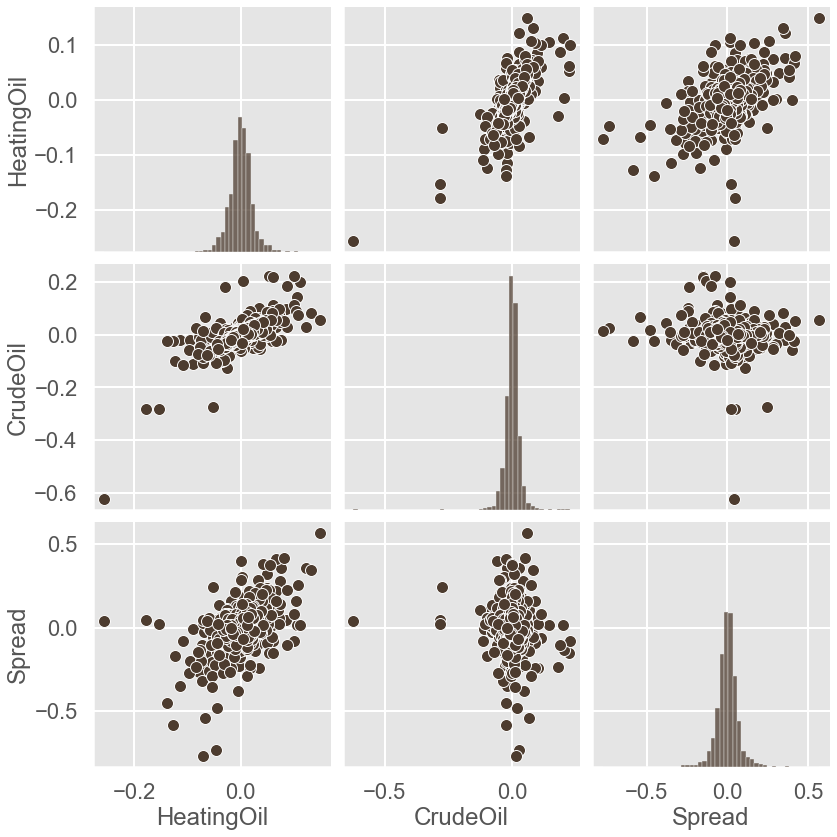

In [11]:
_ = sns.pairplot(logrets_df, height=4, aspect=1,
                 diag_kws = {'color': palette[0], 'bins': 50},
                 plot_kws = {'color': palette[0]})
plt.savefig(f'img/PairPlot.{fmt}', format=fmt)

In [12]:
import seaborn as sns
plt.style.use('ggplot-ubs.mplstyle')
sns.set_context('talk')
sns.color_palette()

[(0.30196078431372547, 0.23529411764705882, 0.1843137254901961),
 (0.7529411764705882, 0.44313725490196076, 0.33725490196078434),
 (0.9098039215686274, 0.7803921568627451, 0.403921568627451),
 (0.6431372549019608, 0.21568627450980393, 0.1450980392156863),
 (0.8117647058823529, 0.7411764705882353, 0.6078431372549019),
 (0.6823529411764706, 0.6901960784313725, 0.7019607843137254),
 (0.9294117647058824, 0.8431372549019608, 0.615686274509804),
 (0.4823529411764706, 0.49019607843137253, 0.5019607843137255),
 (0.9019607843137255, 0.7137254901960784, 0.6431372549019608),
 (0.27450980392156865, 0.2784313725490196, 0.28627450980392155),
 (0.6313725490196078, 0.8, 0.8941176470588236),
 (0.0, 0.5372549019607843, 0.5529411764705883),
 (0.7254901960784313, 0.6980392156862745, 0.6392156862745098),
 (0.22745098039215686, 0.3411764705882353, 0.5411764705882353),
 (0.7529411764705882, 0.8196078431372549, 0.6078431372549019),
 (0.4823529411764706, 0.4196078431372549, 0.34901960784313724),
 (0.6862745098039216, 0.7372549019607844, 0.8352941176470589),
 (0.4588235294117647, 0.592156862745098, 0.19215686274509805),
 (0.8784313725490196, 0.8352941176470589, 0.7411764705882353),
 (0.21176470588235294, 0.5725490196078431, 0.792156862745098),
 (0.6509803921568628, 0.7450980392156863, 0.396078431372549),
 (0.4235294117647059, 0.5294117647058824, 0.7019607843137254),
 (0.7529411764705882, 0.6, 0.4745098039215686),
 (0.592156862745098, 0.8274509803921568, 0.8),
 (0.43529411764705883, 0.7137254901960784, 0.8745098039215686),
 (0.8745098039215686, 0.6784313725490196, 0.13333333333333333),
 (0.3333333333333333, 0.6941176470588235, 0.7058823529411765)]

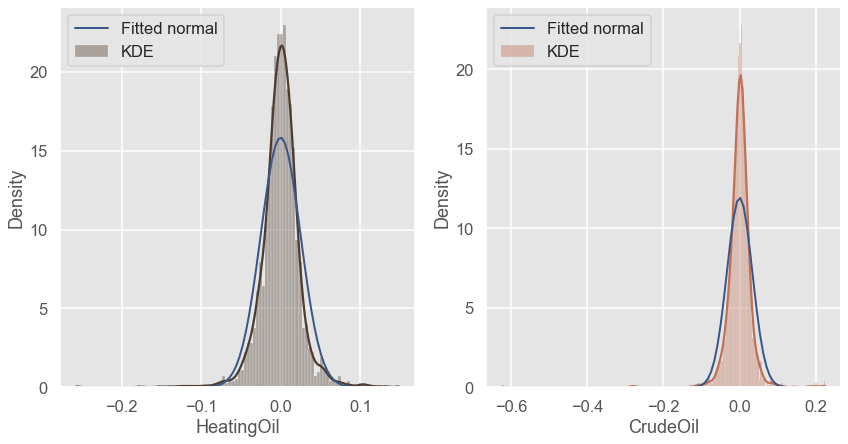

In [13]:
def plot_norm_fit(axes, data):
    xmin, xmax = data.min(), data.max()
    x = np.linspace(xmin, xmax, 100)
    fit = norm.fit(data)
    p = norm.pdf(x, *fit)
    axes.plot(x, p, linewidth=2, color = palette[13], label = 'Fitted normal')
    axes.legend()

fig, ax = plt.subplots(1, 2)
norm_fits = [norm.fit(data) for data in [logrets_df.HeatingOil, logrets_df.CrudeOil]]
sns.histplot(logrets_df.HeatingOil, alpha=0.4, kde=True, stat='density', ax = ax[0],
             color=palette[0], label = 'KDE')
plot_norm_fit(ax[0], logrets_df.HeatingOil)

sns.histplot(logrets_df.CrudeOil, alpha=0.4, kde =True, stat='density', ax = ax[1],
             color=palette[1], label = 'KDE')
plot_norm_fit(ax[1], logrets_df.CrudeOil)
plt.savefig(f'img/KDEs.{fmt}', format=fmt)

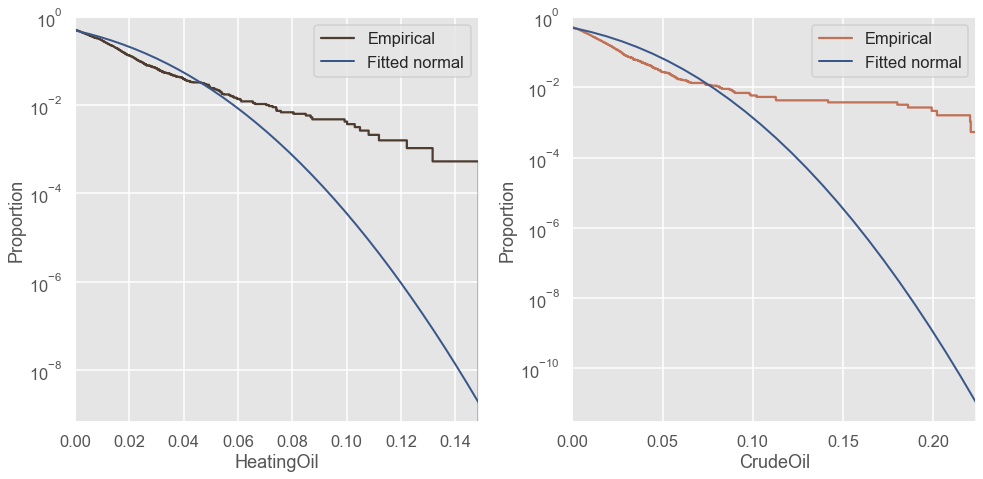

In [14]:
def plot_fit_survival(axes, data):
    xmin, xmax = data.min(), data.max()
    x = np.linspace(xmin, xmax, 100)
    fit = norm.fit(data)
    p = 1 - norm.cdf(x, *fit)
    axes.plot(x, p, color = palette[13], linewidth=2, label='Fitted normal')

fig, ax = plt.subplots(1, 2)
logscale = True

sns.ecdfplot(logrets_df.HeatingOil, ax = ax[0], complementary=True, label='Empirical', color=palette[0])
plot_fit_survival(ax[0], logrets_df.HeatingOil)
ax[0].set_xlim(0, logrets_df.HeatingOil.max())

sns.ecdfplot(logrets_df.CrudeOil, ax = ax[1], complementary=True, label = 'Empirical', color=palette[1])
plot_fit_survival(ax[1], logrets_df.CrudeOil)
ax[1].set_xlim(0, logrets_df.CrudeOil.max())

if logscale:
    ax[1].set_yscale('log')
    ax[0].set_yscale('log')
    #plt.suptitle(r'Tail analysis - power law: $ 1-F_X(x)\sim x^{- \alpha } $')
else:
    ax[0].set_ylim(0, 0.5)
    ax[1].set_ylim(0, 0.5)
    #plt.suptitle("Tail analysis")

ax[0].legend()
ax[1].legend()
plt.tight_layout()
plt.savefig(f'img/TailAnalysis.{fmt}', format=fmt)

## Time Series Analysis of marginals


#### Mean model? 

> **Def** ARIMA(p,d,q) model
>
> Modele ARIMA to modele wyjaśniające dynamikę wartości średnich szeregów czasowych. W ogólności opisujemy je równaniem:
>
> $$ (1 - \phi_1B - \phi_2B^2 - \dots - \phi_pB^p)(1-B)^dX_t = (1+\theta_1B + \theta_2B^2 + \dots + \theta_qB^q)\epsilon_t > +c$$ 
>
> Gdzie $\phi(B)$ to wielomian odpowiadający za autoregresję, $\theta(B)$ to za średnią ruchomą, a $(1-B)^d$ wprowadza wpływ  różnicowania.

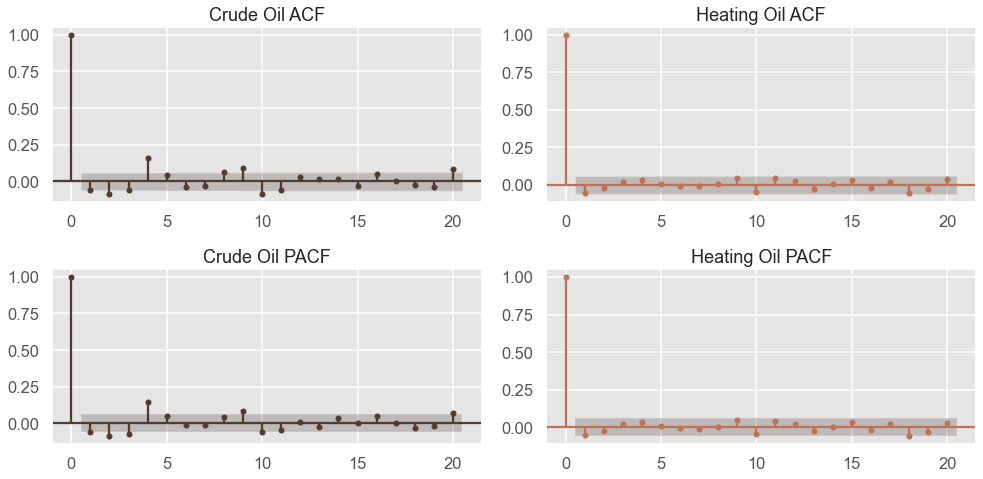

In [15]:
fig, ax = plt.subplots(2, 2)

zero=True
_ = tsaplots.plot_acf(logrets_df.CrudeOil, title="Crude Oil ACF",
                      ax = ax[0][0], zero=zero, alpha=0.01, lags=20, color=palette[0])
_ = tsaplots.plot_pacf(logrets_df.CrudeOil, title="Crude Oil PACF",
                       ax = ax[1][0], zero=zero, alpha = 0.01, lags=20, color=palette[0])

_ = tsaplots.plot_acf(logrets_df.HeatingOil, title="Heating Oil ACF",
                      ax = ax[0][1], zero=zero, alpha = 0.01, lags=20, 
                      color=palette[1], vlines_kwargs={"colors": palette[1]})
_ = tsaplots.plot_pacf(logrets_df.HeatingOil, title="Heating Oil PACF",
                       ax = ax[1][1], zero=zero, alpha =0.01, lags = 20,
                       color=palette[1], vlines_kwargs={"colors": palette[1]})

#plt.suptitle("Logreturns TSA")
plt.tight_layout()
plt.savefig(f"img/TSA.{fmt}", format=fmt)

In [16]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("Reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis indicating it is non-stationary ")

print("Crude Oil logreturns:")
adfuller_test(logrets_df.CrudeOil)

print("")
print("Heating Oil logreturns:")
adfuller_test(logrets_df.HeatingOil)

Crude Oil logreturns:
ADF Test Statistic : -7.665748066763906
p-value : 1.643006456169625e-11
#Lags Used : 22
Number of Observations : 1854
Reject the null hypothesis. Data is stationary

Heating Oil logreturns:
ADF Test Statistic : -45.60930833560821
p-value : 0.0
#Lags Used : 0
Number of Observations : 1876
Reject the null hypothesis. Data is stationary


#### Variance model ?

> **Def** GARCH(p, q) 
>
> Model GARCH to model wyjaśniający heteroskedastyczność szeregu czasowego. Dokonujemy w nim autoregresji, oraz regresji na wartości szeregu:
>
> $$ \epsilon_t  = \sigma_t \cdot e_t $$
>
> $$ \sigma^2_t = \omega + \Sigma_{i=1}^{p} \alpha_i \epsilon^2_{t-i} + \Sigma_{j=1}^q\beta_j \sigma^2_{t-j} $$
> 
> W powyższych równaniach $e_t$ to biały szum.

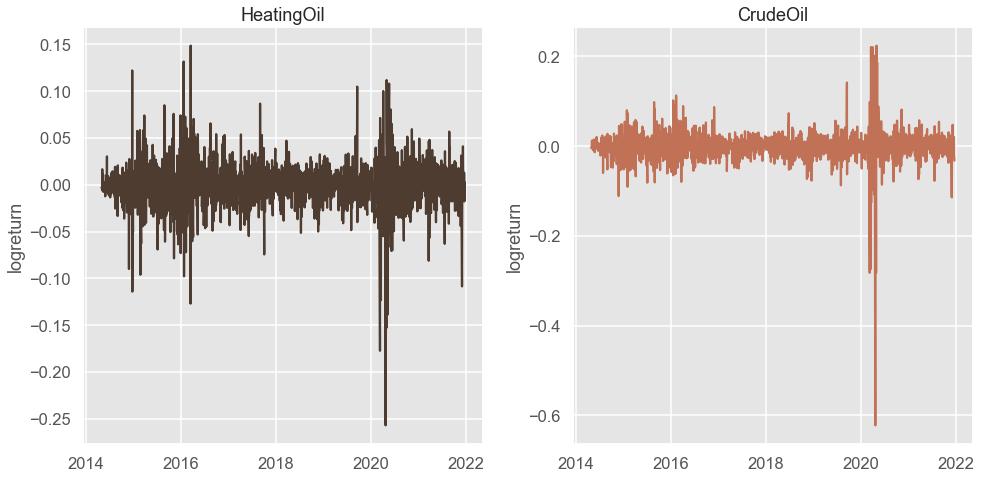

In [17]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(1, 2)
asset_palette = {'HeatingOil': palette[0], 'CrudeOil': palette[1]}

for i, asset in enumerate(['HeatingOil', 'CrudeOil']):
    ax[i].plot(logrets_df.loc[:, asset], label=asset, color=asset_palette[asset])
    ax[i].set_title(asset);
    ax[i].set_ylabel('logreturn')
    ax[i].xaxis.set_major_locator(mdates.YearLocator(2))

plt.tight_layout()
plt.savefig(f'img/Heteroskedasticity.{fmt}', format=fmt)

In [18]:
from arch import arch_model

garch_models={}
garch_residuals ={}
for asset in ['HeatingOil', 'CrudeOil']:
    model = arch_model(logrets_df.loc[:, asset], mean='Constant', vol='GARCH', p=1, q=1, dist='normal', rescale=True)
    res = model.fit(disp='off')
    garch_models[asset] = res
    garch_residuals[asset] = res.resid/res.conditional_volatility
    
garch_residuals = pd.DataFrame.from_dict(garch_residuals)

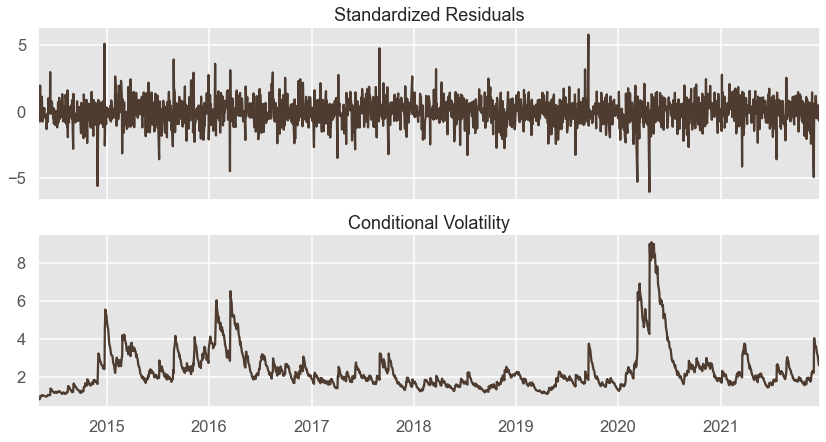

In [19]:
_ = garch_models['HeatingOil'].plot()
plt.savefig(f'img/GARCH.{fmt}', format=fmt)

---

## Copulas (theory)

### Formalna definicja


> Dwuwymiarową kopułą nazywamy funkcję:
> $C: [0, 1]^2 \rightarrow \mathbb{R}, $
> spełniającą warunki:
> * $C(u, 0) = C(0, v) = 0$ (grounded)
> * $C(u, 1) = u \wedge C(1, v)=v$ 
> * $2$-rosnąca

Oznaczmy przez $F_{XY}$ dystrybuantę rozkładu łącznego, $F_X(x)$, $F_Y(y)$ rozkłady brzegowe. Wtedy istnieje dwuwymiarowa kopuła $C$, taka że: 

$$F_{XY}(x, y) = C(F_X(x), F_Y(y)).$$ 

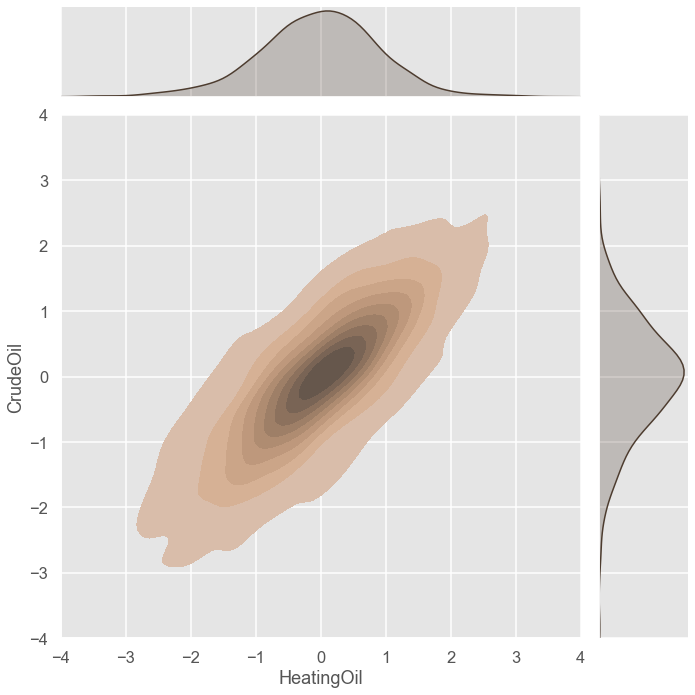

In [20]:
_=sns.jointplot(
    data=garch_residuals,
    x="HeatingOil", y="CrudeOil",
    height=10, kind="kde", 
    fill=True, xlim=(-4, 4), ylim=(-4, 4))

plt.savefig(f'img/Jointplot.{fmt}', format=fmt)

### Probability Integral Transform

**Idea:** 
* Mając pewną zmienną losową $X$ o ciągłej i odwracalnej dystrybuancie $F(x)$, możemy losować jej realizację losując najperw realizację z rozkładu jednostajnego $u \sim U(0, 1)$ i przyjmując $ x = F^{-1}(u)$. 

To jest metoda odwrotnej dystrybuanty, przydatna w symulacjach. To teraz spójrzmy na to na odwrót:

* Mając pewną zmienną losową $X$ o dystrybuancie $F(x)$ oraz jej realizację $y$, możemy losować realizację z rozkładu jednostajnego przyjmując $u = F(y).$

To jest tzw. *probability integral transform*, i pomoże nam ujednostajnić rozkłady brzegowe wielowymiarowych rozkładów.

> **Tw: (Probability Integral Transform)**
>
>*Założenia:* Zmienna losowa $X$ ma ciągłą dystrybuantę $F_X(x)$.
>
>*Teza:* $F_X(X)\sim U(0, 1)$
>
>*Dowód:*
>
>Zdefiniujmy $Y=F_X(X)$ i zbadajmy rozkład tej zmiennej losowej. Mamy:
>
>$$ P( Y \leq y)  = P\big( F_X(X) \leq y \big) = P\big( X \leq F_X^{-1}(y)\big) = F_X(F^{-1}(y)) = y.$$
>
> Powyższe to dystrybuanta zmiennej losowej jednostajnej, c.n.d.

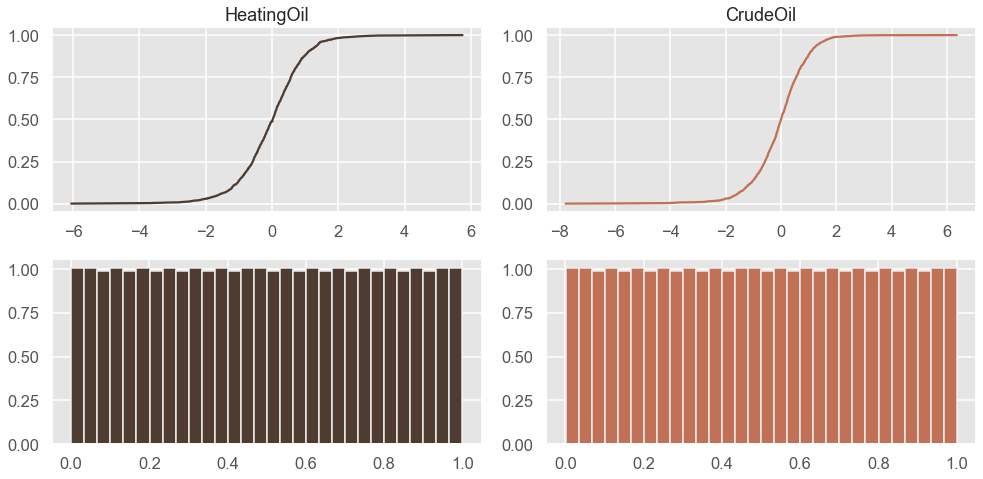

In [21]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdfs = {asset: ECDF(garch_residuals[asset]) for asset in ['HeatingOil', 'CrudeOil']}

fig, ax = plt.subplots(2, 2)

for ind, asset in enumerate(['HeatingOil', 'CrudeOil']):
    x = garch_residuals[asset].sort_values()
    ax[0][ind].plot(x, ecdfs[asset](x), color=asset_palette[asset])
    ax[0][ind].set_title(f"{asset}")
    ax[1][ind].hist(ecdfs[asset](x), density=True, bins=30, color = asset_palette[asset])

plt.tight_layout()
plt.savefig(f'img/ECDFs.{fmt}', format=fmt)

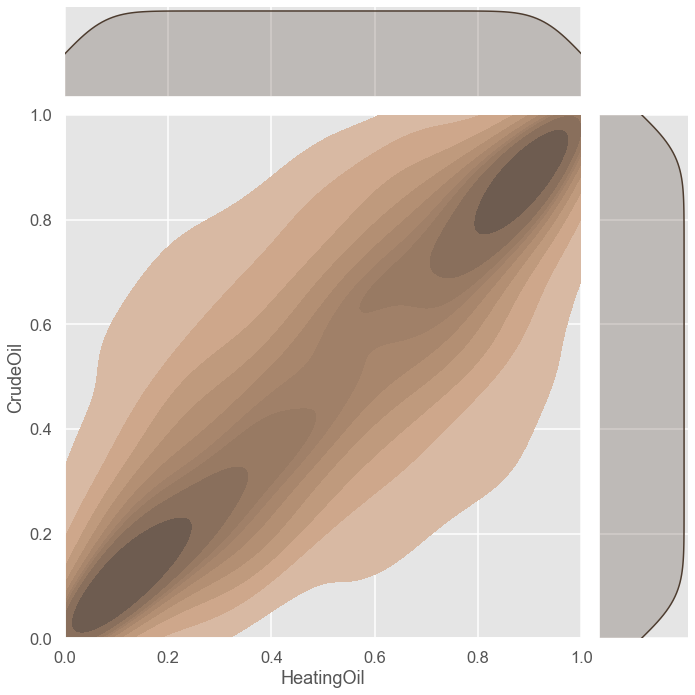

In [22]:
garch_residuals_u_df = logrets_df.iloc[:, 0:2].copy()
for ind, asset in enumerate(['HeatingOil', 'CrudeOil']):
    garch_residuals_u_df[asset] = ecdfs[asset](garch_residuals[asset])

_=sns.jointplot(
    data=garch_residuals_u_df,
    x="HeatingOil", y="CrudeOil",
    height=10, kind="kde", 
    fill=True, xlim=(0, 1), ylim=(0, 1))
plt.savefig(f'img/Jointplot_copula.{fmt}', format = fmt)

### Rodzaje kopuł

Mamy całe zoo możliwych kopuł.

* Minimum copula: $C(u_1, u_2) = \min{(u_1, u_2)} $
* Independence copula: $C(u_1, u_2) = u_1u_2$
* Maximum copula: $C(u_1, u_2) = \max{(u_1 + u_2 - 1, 0)} $

> *Tw. Fréchet–Hoeffding*
>
> Dla dowolnej kopuły $C(u_1, u_2)$ mamy ograniczenia dolne i górne:
>
> $$ \max{(u_1 + u_2 - 1, 0)} \leq C(u_1, u_2) \leq \min{(u_1, u_2)}$$ 
>

**Multivariate Copulas**

* Gaussian copula: $C(\mathbf{u}; \Sigma) = \Phi_\Sigma\big(\Phi^{-1}(u_1), \dots, \Phi^{-1}(u_d)\big)$

* Student copula: $C(\mathbf{u}; \Sigma, \nu) = T_{\Sigma, \nu}\big(T_{\nu}^{-1}(u_1), \dots, T_{\nu}^{-1}(u_d)\big) \ $


**Archimedean Copulas**

* Clayton copula: $C(u_1, u_2; \delta) = (u_1^{-\delta} + u_2^{-\delta} - 1)^{-\frac{1}{\delta}}$

* Gumbel copula: $C(u_1, u_2; \delta) = \exp{[-\{(-\ln{u_1})^{\delta} + (-\ln{u_2})^{\delta}\}^{\frac{1}{\delta}}]}$

* Frank copula: $C(u_1, u_2; \delta) = -\frac{1}{\delta}\ln{\bigg(\frac{1}{1-e^{-\delta}}\big[(1-e^{-\delta}) - (1-e^{-\delta u_1})(1-e^{-\delta u_2}) \big]\bigg)} $

* Joe copula: $C(u_1, u_2; \delta) = 1 - \bigg( (1-u_1)^{\delta} + (1-u_2)^{\delta} - (1-u_1)^{\delta}(1-u_2)^{\delta} \bigg)^{\frac{1}{\delta}} $

In [23]:
import pyvinecopulib as pv
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.templates.default = "ggplot2"

def plot_copula_surface(cop, cop_family_name, colorscale = 'turbid_r'):
    margin = 0.05

    x = np.linspace(margin, 1-margin, 100)
    y = np.linspace(margin, 1-margin, 100)
    X,Y = np.meshgrid(x,y)
    points2D = np.vstack([X.flatten(),Y.flatten()]).T

    Z = cop.pdf(points2D)
    Z = np.reshape(Z, np.shape(X))

    fig = go.Figure(data=[go.Surface(z=Z, x=X, y=Y, 
                                     colorscale=colorscale, showscale=False, 
                                     contours = {"z": {"show": True, 
                                                       "start": Z.min(),
                                                       "end": Z.max(), 
                                                       "size": 0.5, 
                                                       "color": "white"}})])

    camera = dict(
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-0.8, y=-1.35, z=1))

    fig.update_layout(title=f"{cop_family_name} copula", autosize=False,
                      width=500, height=500,
                      margin=dict(l=0, r=0, b=10, t=40), scene_camera=camera)
    return fig

def plot_copula_contour(cop, cop_family_name, colorscale = 'turbid_r', 
                        n_contours= 20, margin = 0.05, contour_margin=0.05,
                        fill=True, scale_normal=False):
    
    if scale_normal:
        margin = 0.05
        x = np.linspace(-3+margin, 3-margin, 100)

        X,Y = np.meshgrid(x,x)
        NX = norm.cdf(X)
        NY = norm.cdf(Y)
        NGRID = np.stack((np.ravel(NX),np.ravel(NY)), axis = 1)

        nx = norm.pdf(x).reshape((1,len(x)))
        adj = (nx.transpose()*nx).ravel()

        nx = norm.pdf(x).reshape((1,len(x)))
        adj = (nx.transpose()*nx).ravel()

        Z = cop.pdf(NGRID)
        Z = np.reshape(Z*adj, np.shape(X))
    else:
        x = np.linspace(margin, 1-margin, 100)
        y = np.linspace(margin, 1-margin, 100)
        X,Y = np.meshgrid(x,y)
        points2D = np.vstack([X.flatten(),Y.flatten()]).T

        Z = cop.pdf(points2D)
        Z = np.reshape(Z, np.shape(X))

    c_start = np.quantile(Z, contour_margin/2)
    c_end = np.quantile(Z, 1 - contour_margin/2)
    c_size = (c_end - c_start)/n_contours
    if fill:
        fig = go.Figure(data=[go.Contour(z= Z,x= x, y= x,
                                         line_smoothing = 0,
                                         colorscale = colorscale,
                                         contours=dict(start=c_start,
                                                       end=c_end,
                                                       size=c_size))])
    else:
        fig = go.Figure(data=[go.Contour(z=Z,x =x, y=x,
                                         contours_coloring='lines',
                                         line_width=2,
                                         colorscale=colorscale,
                                         contours=dict(start=c_start,
                                                       end=c_end,
                                                       size=c_size))])
    camera = dict(
        center=dict(x=0, y=0, z=0),
        eye=dict(x=-0.8, y=-1.35, z=1))

    fig.update_layout(title=f"{cop_family_name} copula", autosize=False,
                      width=500, height=500,
                      margin=dict(l=0, r=0, b=10, t=40), scene_camera=camera)
    return fig

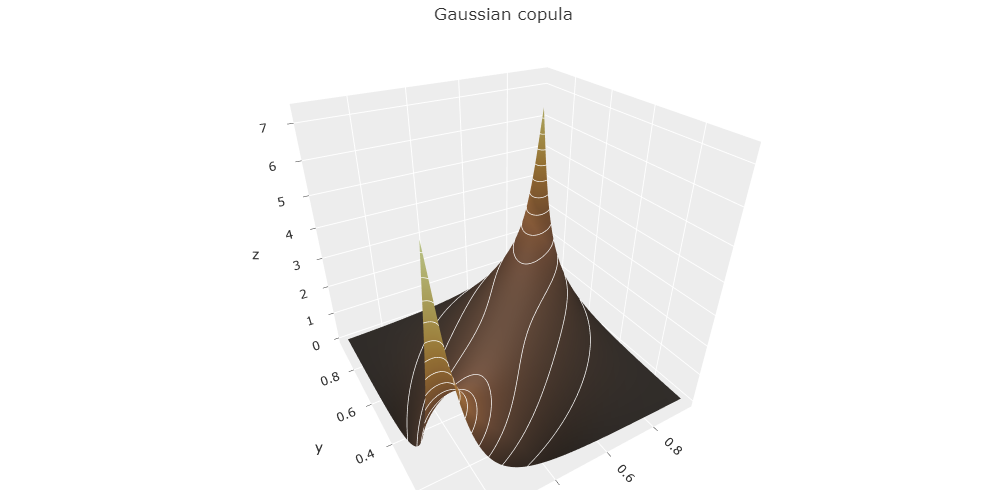

In [24]:
cop = pv.Bicop(family=pv.BicopFamily.bb1)
cop.fit(data = garch_residuals_u_df)

plot_copula_surface(cop, "Gaussian")

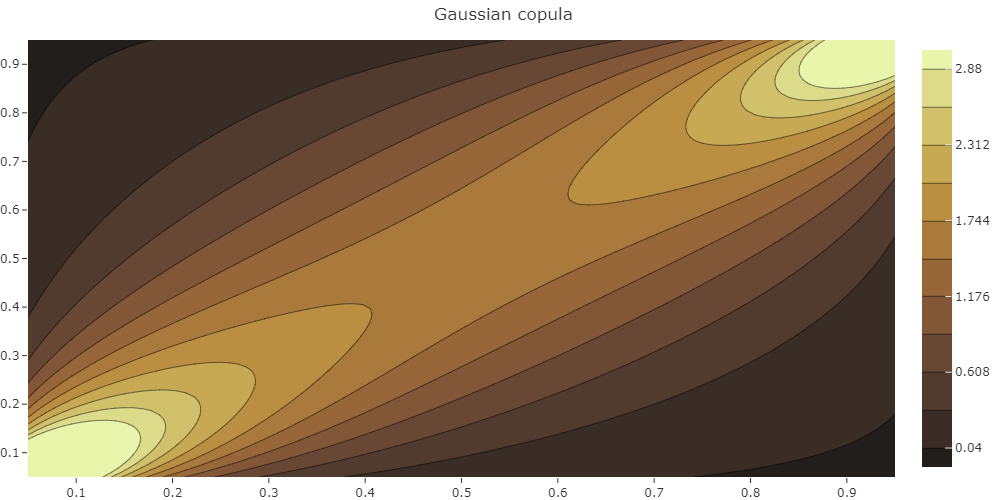

In [25]:
cop = pv.Bicop(family=pv.BicopFamily.bb1)
cop.fit(data = garch_residuals_u_df)

plot_copula_contour(cop, "Gaussian", n_contours = 10)

In [26]:
fits = {}
copula_figures = {}
family_set = pv.parametric

controls = pv.FitControlsBicop(family_set = family_set, selection_criterion='aic')

for copula_family in family_set:
    cop = pv.Bicop(family=copula_family)
    cop.fit(garch_residuals_u_df, controls=controls)
    fits[copula_family.name] = cop
    copula_figures[copula_family.name] = plot_copula_surface(cop, copula_family.name, "turbid_r")

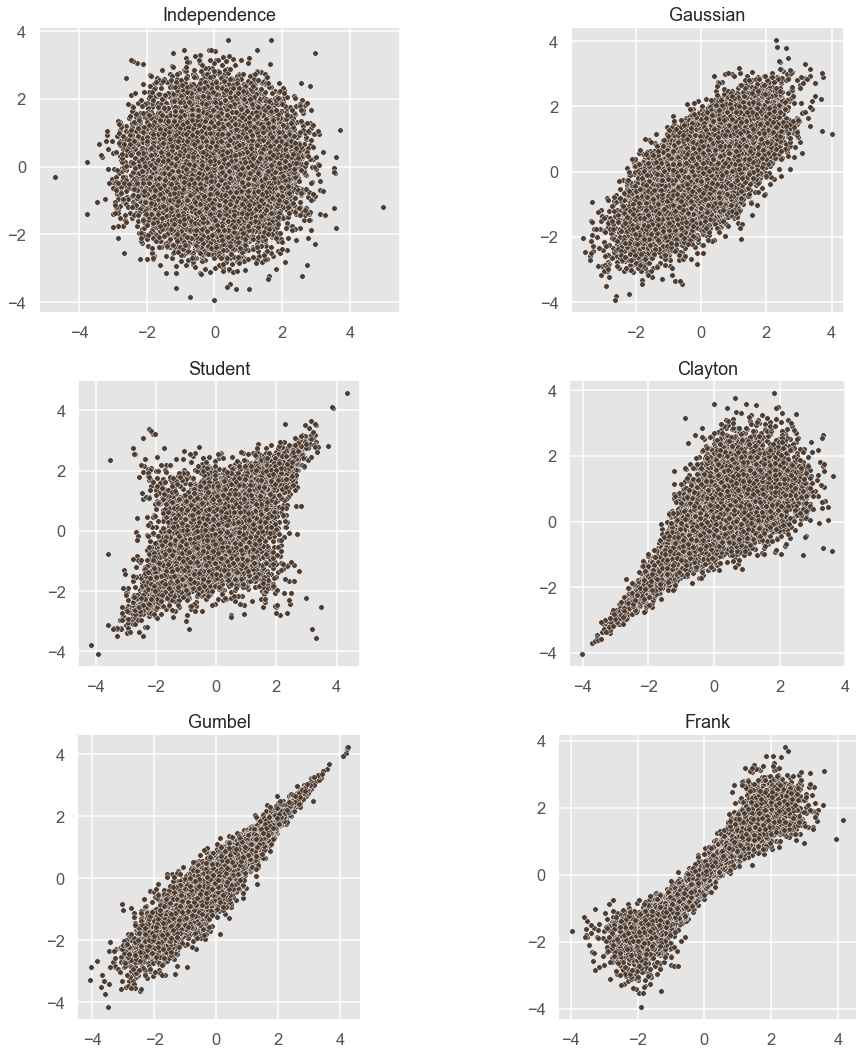

In [27]:
fmt = 'png'
cops = {'Independence': pv.Bicop(family = pv.indep),
        'Gaussian': pv.Bicop(family = pv.gaussian, parameters = [0.7]), 
        'Student': pv.Bicop(family=pv.student, parameters=[0.7, 2]),
        'Clayton': pv.Bicop(family=pv.clayton, parameters=[3]), 
        'Gumbel': pv.Bicop(family=pv.gumbel, parameters=[5]),
        'Frank': pv.Bicop(family=pv.frank, parameters=[30])}

fig, ax = plt.subplots(3, 2, figsize=(15, 15))
for (name, copula), axis in zip(cops.items(), ax.ravel()):
    data_u_sim = pd.DataFrame(copula.simulate(n=20000), 
                              columns = ["HeatingOil", "CrudeOil"])
    data_u_sim = data_u_sim.apply(lambda x: norm.ppf(x))
    sns.scatterplot(data = data_u_sim, x="HeatingOil", y="CrudeOil", s=30, ax = axis)
    axis.set_xlabel("")
    axis.set_ylabel("")
    axis.set_title(name)
    axis.set_aspect('equal')
    
plt.tight_layout()
plt.savefig(f'img/CopulaTypes.{fmt}', format=fmt)
fmt='svg'

In [30]:
fmt = 'svg'
cops = {'Independence': pv.Bicop(family = pv.indep),
        'Gaussian': pv.Bicop(family = pv.gaussian, parameters = [0.7]), 
        'Student': pv.Bicop(family=pv.student, parameters=[0.7, 2]),
        'Clayton': pv.Bicop(family=pv.clayton, parameters=[2]), 
        'Gumbel': pv.Bicop(family=pv.gumbel, parameters=[2]),
        'Frank': pv.Bicop(family=pv.frank, parameters=[9])}

for name, cop in cops.items():
    subfig = plot_copula_contour(cop, cop_family_name = name, scale_normal=False, fill=False, contour_margin = 0)
    #subfig.update_layout(yaxis=dict(range=[-3, 3]))
    subfig.update_yaxes(scaleanchor = "x", scaleratio = 1)
    subfig.write_image(f"img/{name}Contour.{fmt}", scale=3)

In [32]:
fmt = 'svg'
cops = {'Independence': pv.Bicop(family = pv.indep),
        'Gaussian': pv.Bicop(family = pv.gaussian, parameters = [0.7]), 
        'Student': pv.Bicop(family=pv.student, parameters=[0.7, 2]),
        'Clayton': pv.Bicop(family=pv.clayton, parameters=[2]), 
        'Gumbel': pv.Bicop(family=pv.gumbel, parameters=[2]),
        'Frank': pv.Bicop(family=pv.frank, parameters=[9])}

for name, cop in cops.items():
    subfig = plot_copula_surface(cop, cop_family_name = name)
    subfig.write_image(f"img/{name}Surf.{fmt}", scale=3)


In [25]:
from jupyter_dash import JupyterDash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output
import plotly.express as px

app = JupyterDash(__name__)
height = 500
width = 500

family_names = fits.keys()

app.layout = html.Div([
    html.P("Fitted copula"),
    dcc.Dropdown(
        id='copula_family', 
        options=[{"value": x, "label": x} 
                 for x in family_names],
        value='gaussian'
    ),
    dcc.Graph(id="graph"),
])

@app.callback(
    Output("graph", "figure"), 
    [Input("copula_family", "value")])
def change_colorscale(copula_family):
    fig = copula_figures[copula_family]
    return fig

app.run_server(
    mode="inline",
    port=8070,
    dev_tools_ui=True,
    debug=True,
    dev_tools_hot_reload=True,
    threaded=True,
)

### Best fit

Modelując rozkłady wielowymiarowe za pomocą kopuł, dostajemy kolejne wygodne narzędzie - metodę estymacji *Inference for Margins (IFM)*

> **Algorytm**: IFM dla rozkładu $d$-wymiarowego
> 
> Z twierdzenia Sklara wiemy, że ciągłe rozkłady wielowymiarowe można rozbić na kopułę i rozkłady brzegowe
> To pozwala na zapisanie gęstości łącznej w formie:
> $$ f(x_1, x_2, \dots, x_d) = c\big(F_1(x_1), F_2(x_2), \dots, F_d(x_d)\big)\Pi_{i=1}^d f_i(x_i). $$
>
> W wyniku czego, log-likelihood przyjmuje bardzo wygodną postać:
>
> $$ \ln{f(x_1, x_2, \dots, x_d)} = \ln{c\big(F_1(x_1), F_2(x_2), \dots, F_d(x_d)\big)} +  \Sigma_{i=1}^d \ln{f_i(x_i)} $$
>
> A cały algorytm dopasowywania rozkładu rozbija się na osobno:
> 
> * estymację wektora parametrów dla rozkładów brzegowych: $\hat{\theta}_m = \text{argmin}_{\theta_m}\big[\Sigma_{i=1}^d \ln{f_i(x_i; \theta_m)}\big]$
> * estymację wektora parametrów dla kopuły: $\hat{\theta}_c = \text{argmin}_{\theta_c}\big[\ln{c\big(F_1(x_1), F_2(x_2), \dots, F_d(x_d); \theta_c, \hat{\theta}_m\big)}\big]$
>
> Estymatorem IMF jest wektor $\hat{\theta}_{IMF} = (\hat{\theta}_m, \hat{\theta}_c)$



Fit controls:
---------
<pyvinecopulib.FitControlsBicop>
Family set: Independence, Gaussian, Student, Clayton, Gumbel, Frank, Joe, BB1, BB6, BB7, BB8
Parametric method: mle
Nonparametric method: quadratic
Nonparametric multiplier: 1
Weights: no
Selection criterion: aic
Preselect families: yes
mBIC prior probability: 0.9
Number of threads: 1


Fit results:
------------
              loglik          aic          bic
indep       0.000000     0.000000     0.000000
gaussian  891.312771 -1780.625543 -1775.088112
student   937.911963 -1871.823926 -1860.749066
clayton   756.683166 -1511.366333 -1505.828903
gumbel    843.068423 -1684.136846 -1678.599416
frank     842.153583 -1682.307167 -1676.769737
joe       644.746312 -1287.492624 -1281.955194
bb1       929.587802 -1855.175604 -1844.100744
bb6       843.068290 -1682.136581 -1671.061721
bb7       941.540632 -1879.081263 -1868.006403
bb8       818.951956 -1633.903912 -1622.829051

Best fit:
---------
<pyvinecopulib.Bicop>
BB7, parameters = 1.8

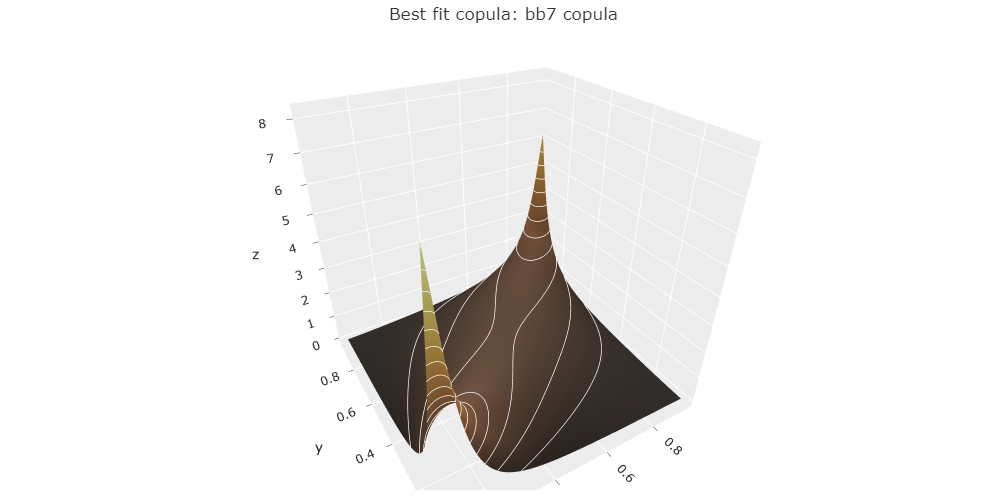

In [33]:
best_fit = pv.Bicop()

best_fit.select(data = garch_residuals_u_df, controls = controls)  
fit_results = {}
for family, fitted_copula in fits.items():
    fit_results[family] = {'loglik': fitted_copula.loglik(garch_residuals_u_df),
                           'aic': fitted_copula.aic(garch_residuals_u_df),
                           'bic': fitted_copula.bic(garch_residuals_u_df)}
print(f"""
Fit controls:
---------
{controls}

Fit results:
------------
{pd.DataFrame.from_dict(fit_results, orient='index')}

Best fit:
---------
{best_fit}""")

plot_copula_surface(best_fit, f"Best fit copula: {best_fit.family.name}")

In [37]:
fig = plot_copula_surface(best_fit, "Best fit: BB7(1.81, 1.54)")
fig.write_image(f"img/BestFitSurface.{fmt}", scale=3)

fig = plot_copula_contour(best_fit, "Best fit: BB7(1.81, 1.54)", scale_normal=True, fill=False, contour_margin=0)
fig.write_image(f"img/BestFitContourNorm.{fmt}", scale=3)

fig = plot_copula_contour(best_fit, "Best fit: BB7(1.81, 1.54)", scale_normal=False, fill=False, contour_margin=0)
fig.write_image(f"img/BestFitContour.{fmt}", scale=3)

---
## Monte Carlo Pricing

Mając dopasowany model i w ten sposób wyjaśnioną losowość aktywów, można przystąpić do wyceny Monte Carlo.

**PLAN**:
1. Użyć kopuły i wysymulować zależne od siebie pary zmiennych jednostajnych
2. Metoda odwrotnej dystrybuanty, żeby dostać zależne od siebie zmienne z odpowiednich rozkładów
3. Otrzymujemy w ten sposób szereg par logzwrotów (po jednej parze na każdy dzień/krok, bo mamy 2 aktywa)
4. Z wartości początkowych i logzwrotów odzyskujemy całe time series cen
5. Obliczamy wypłatę z opcji
6. Powtarzamy od początku wiele razy
7. Uśredniamy + dyskontujemy


### Symulowanie z kopuły

Podstawowe pytanie na które należy sobie odpowiedzieć, to jak symulować z pewnej kopuły $C(u_1, u_2)$ ? W przypadku kopuł parametrycznych, jest to stosunkowo łatwe.

Kluczem jest uświadomienie sobie, że kopuły to dystrybuanty, więc można robić takie sztuczki, jak wyznaczanie rozkładów warunkowych:

> **Def** Kopuła warunkowa (conditonal copula)
>
> Mając różniczkowalną kopułę $C_{12}(u_1, u_2)$, możemy zdefiniować kopułę warunkową $C_{1|2}(u_1|u_2)$ jako:
>
> $$C_{1|2}(u_1|u_2) = \frac{\partial}{\partial u_2}C_{12}(u_1, u_2)$$
>
> Odpowiada ona rozkładowi warunkowemu $(U_1 | U_2)$

> **Algorytm** Symulacja zmiennych jednostajnych według ich kopuły
> 
> * Symulujemy zmienną jednostajną $u_1$
> * Symulujemy zmienną jednostajną $v_2$
> * $u_2 = C^{-1}_{2|1}(v_2|u_1)$
> 
> Wtedy para $(u_1, u_2)$ pochodzi z rozkładu zadanego kopułą $C_{12}$ 
>


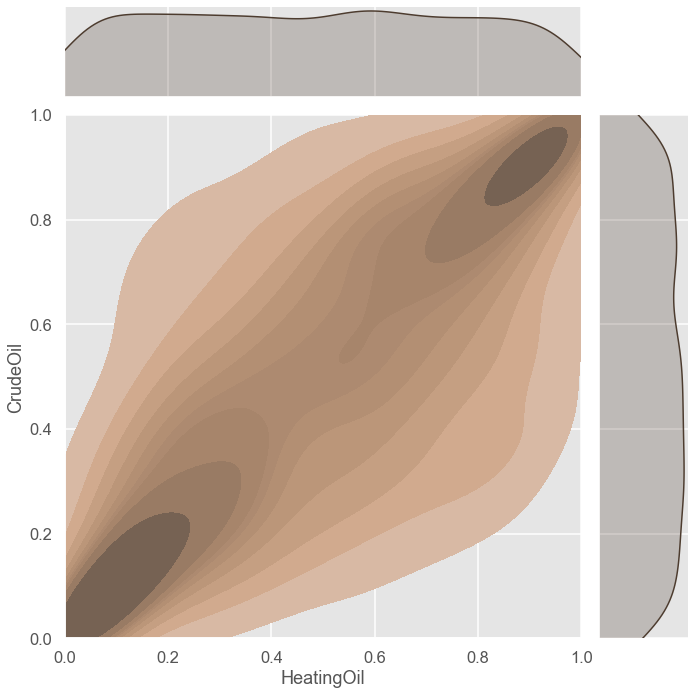

In [70]:
data_u_sim = pd.DataFrame(best_fit.simulate(n=garch_residuals_u_df.shape[0]), columns = ["HeatingOil", "CrudeOil"])

_=sns.jointplot(
    data=data_u_sim,
    x="HeatingOil", y="CrudeOil",
    height=10, kind="kde", 
    fill=True, xlim=(0, 1), ylim=(0, 1))
#plt.savefig(f"img/JointplotSim.{fmt}")

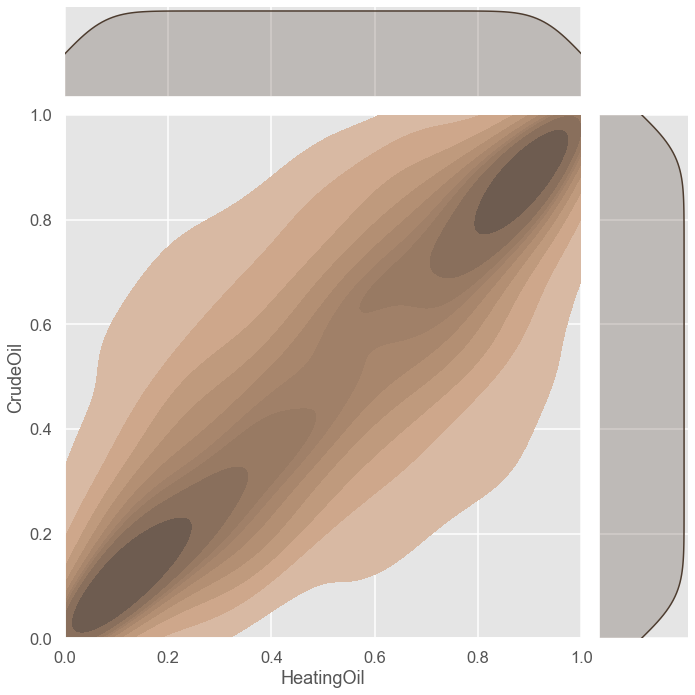

In [48]:
_=sns.jointplot(data=garch_residuals_u_df, x="HeatingOil", y="CrudeOil", height=10, kind="kde", fill=True, xlim=(0, 1), ylim=(0, 1))
#plt.savefig(f"img/JointplotTheo.{fmt}")

Następnie można zastosować dobrane wcześniej dystrybuanty, odwrócić je i zastosować metodę odwrotnej dystrybuanty do zmiennych jednostajnych wysymulowanych z kopuły.

In [71]:
from scipy.interpolate import interp1d

def ppf_HO(x):
    return np.quantile(garch_residuals["HeatingOil"], x)
def ppf_CO(x):
    return np.quantile(garch_residuals["CrudeOil"], x)


ppfs={'HeatingOil': ppf_HO,
      'CrudeOil': ppf_CO}

sim_garch_residuals = pd.DataFrame.from_dict({asset: ppfs[asset](data_u_sim[asset]) for asset in ['HeatingOil', 'CrudeOil']})

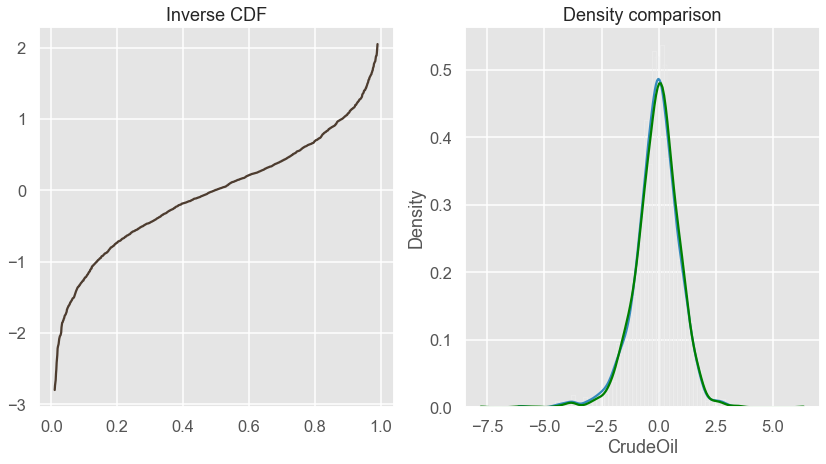

In [72]:
asset_name = 'CrudeOil'
x = np.linspace(0.01, 0.99, 1000)
y = ppfs[asset_name](x)

fig, ax = plt.subplots(1, 2)
ax[0].plot(x, y)
ax[0].set_title('Inverse CDF')
sns.histplot(sim_garch_residuals.loc[:, asset_name], alpha=0, kde=True, stat='density', ax = ax[1])
sns.histplot(garch_residuals.loc[:, asset_name], alpha=0., kde=True, stat='density', ax = ax[1], color='green')
_ = ax[1].set_title("Density comparison")
#plt.savefig(f"img/DensitySim.{fmt}")

Finalnie, otrzymujemy wektor zależnych od siebie par logzwrotow, które możemy przekuć na zależne od siebie trajektorie.

In [65]:
garch_models['HeatingOil'].params

mu          0.026176
omega       0.071907
alpha[1]    0.097879
beta[1]     0.897402
Name: params, dtype: float64

In [73]:
copula_garch_simulated_logrets = {}
for asset in ['HeatingOil', 'CrudeOil']:
    mu, omega, alpha, beta = garch_models[asset].params
    scale = garch_models[asset].scale
    e_t = sim_garch_residuals[asset]

    epsilon_t = [garch_models[asset].resid[0]]
    sigma2_t = [garch_models[asset].conditional_volatility[0]**2]

    for e in e_t:
        epsilon_t.append(e*np.sqrt(sigma2_t[-1]))
        sigma2_t.append(omega + alpha*epsilon_t[-1]**2 + beta*sigma2_t[-1])

    copula_garch_simulated_logrets[asset] = (np.array(epsilon_t) + mu)/scale
copula_garch_simulated_logrets = pd.DataFrame.from_dict(copula_garch_simulated_logrets).iloc[1:, :]
copula_garch_simulated_logrets.index = logrets_df.index

In [74]:
asset = "CrudeOil"
mu, omega, alpha, beta = garch_models[asset].params
scale = garch_models[asset].scale
e_t = sim_garch_residuals[asset]

epsilon_t = [garch_models[asset].resid[0]]
sigma2_t = [garch_models[asset].conditional_volatility[0]**2]

for e in e_t:
    epsilon_t.append(e*np.sqrt(sigma2_t[-1]))
    sigma2_t.append(omega + alpha*epsilon_t[-1]**2 + beta*sigma2_t[-1])
    
epsilon_t = np.array(epsilon_t)/scale

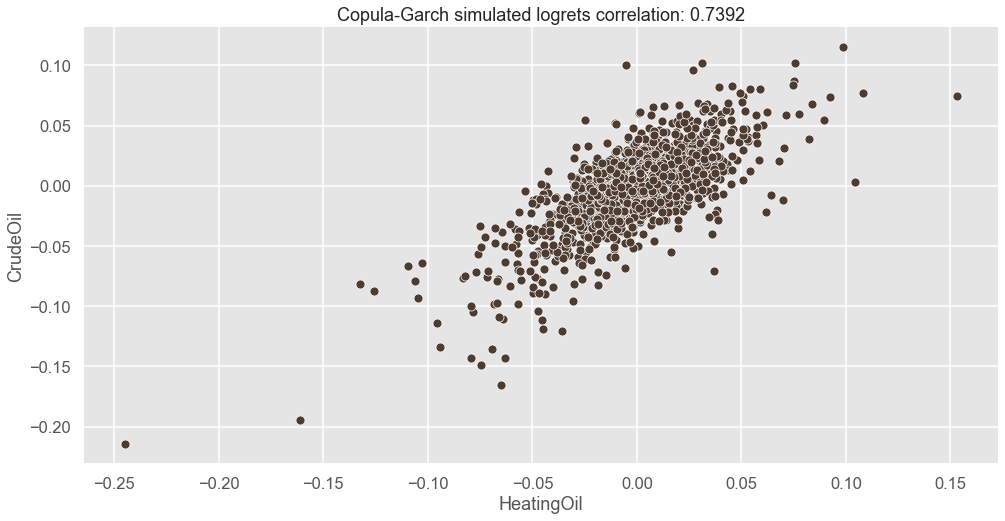

In [75]:
sns.relplot(data = copula_garch_simulated_logrets, x="HeatingOil", y="CrudeOil", height = 7, aspect=2)
corr = copula_garch_simulated_logrets.loc[:, ["HeatingOil", "CrudeOil"]].corr().iloc[1, 0]
_=plt.title(f"Copula-Garch simulated logrets correlation: {corr:.4f}")
#plt.savefig(f"img/LogretsSim.{fmt}")

<AxesSubplot:xlabel='date'>

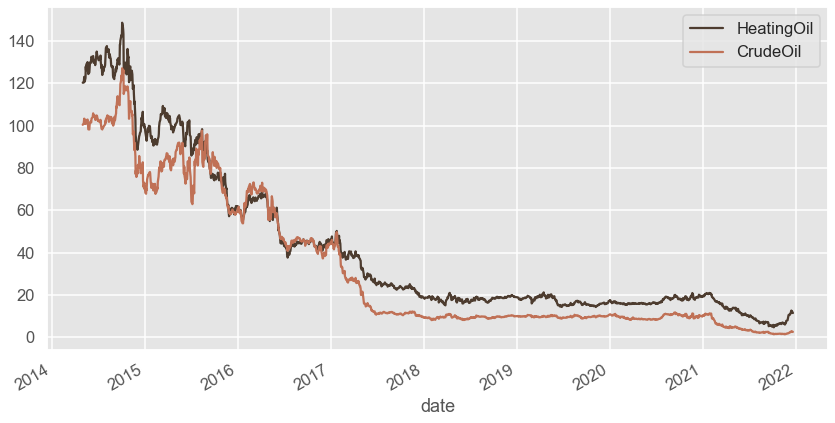

In [76]:
sim_traj_df = pricing_df.iloc[0,0:2]*(np.exp(copula_garch_simulated_logrets.cumsum()))
sim_traj_df.plot()

### Wycena opcji spread

Poskładamy teraz wszystkie elementy układanki:

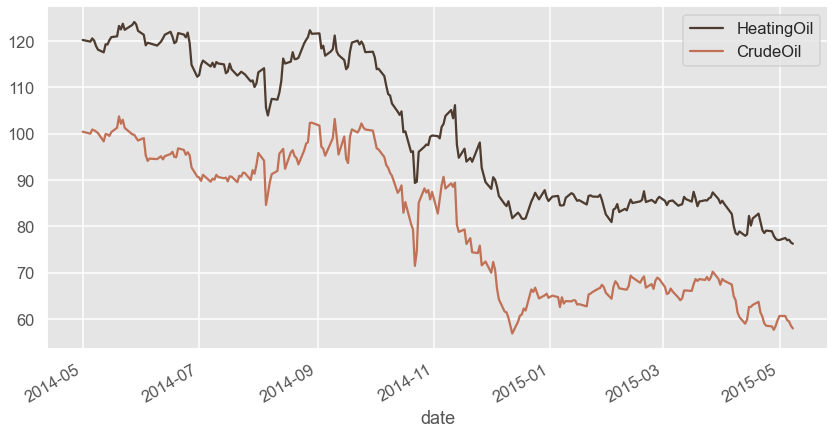

In [84]:
def simulation_run(copula, n_days):
    
    assets = ['HeatingOil', 'CrudeOil']
    data_uniform = pd.DataFrame(copula.simulate(n=n_days), columns = assets)
    sim_garch_residuals = pd.DataFrame.from_dict({asset: ppfs[asset](data_uniform[asset]) for asset in assets})

    copula_garch_simulated_logrets = {}
    for asset in ['HeatingOil', 'CrudeOil']:
        mu, omega, alpha, beta = garch_models[asset].params
        scale = garch_models[asset].scale
        e_t = sim_garch_residuals[asset]

        epsilon_t = [garch_models[asset].resid[0]]
        sigma2_t = [garch_models[asset].conditional_volatility[0]**2]

        for e in e_t:
            epsilon_t.append(e*np.sqrt(sigma2_t[-1]))
            sigma2_t.append(omega + alpha*epsilon_t[-1]**2 + beta*sigma2_t[-1])

        copula_garch_simulated_logrets[asset] = np.array(epsilon_t)/scale
    copula_garch_simulated_logrets = pd.DataFrame.from_dict(copula_garch_simulated_logrets).iloc[1:, :]
    copula_garch_simulated_logrets.index = logrets_df.index[:n_days]
    sim_traj_df = pricing_df.iloc[0,0:2]*(np.exp(copula_garch_simulated_logrets.cumsum()))
    return sim_traj_df
                                
x = simulation_run(best_fit, 252)
x.plot()
#plt.savefig(f"SimulatedPaths.{fmt}")

In [85]:
def payoff(simulation_results, strike, option_type = "CALL"):
    spread_T = simulation_results.HeatingOil[-1] - simulation_results.CrudeOil[-1]
    if option_type == "CALL":
        payoff_ = np.maximum(spread_T - K, 0)
    else:
        payoff_ = np.maximum(K - spread_T, 0)
    return payoff_

MC = 10000
K = 10
T = 1.0
r = 0.05

payoffs_c = np.zeros(MC)
payoffs_p = np.zeros(MC)
spreads = np.zeros(MC)
for mc in range(MC):
    simulation = simulation_run(best_fit, 252)
    spreads[mc] = simulation.HeatingOil[-1] - simulation.CrudeOil[-1]
    payoffs_c[mc] = payoff(simulation, K, "CALL")
    payoffs_p[mc] = payoff(simulation, K, "PUT")

In [101]:
print(f"""
Call spread option
=====================
Instrument: Heating Oil - Crude Oil spread
Price: {(payoffs_c*np.exp(-r*T)).mean():.4f}
Std Err: {(payoffs_c*np.exp(-r*T)).std()/np.sqrt(MC):.4f}

""")

print(f"""
Put spread option
=====================
Instrument: Heating Oil - Crude Oil spread
Price: {(payoffs_p*np.exp(-r*T)).mean():.4f}
Std Err: {(payoffs_p*np.exp(-r*T)).std()/np.sqrt(MC):.4f}

""")


Call spread option
Instrument: Heating Oil - Crude Oil spread
Price: 23.0279
Std Err: 0.3380



Put spread option
Instrument: Heating Oil - Crude Oil spread
Price: 2.5506
Std Err: 0.0904


